In [91]:
import seaborn as sns
import os
import numpy as np
import pandas as pd
import glob
from scipy import signal
import matplotlib.pyplot as plt
import mne
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

In [92]:
import warnings
warnings.filterwarnings('ignore', message='Channel names are not unique')

In [93]:
DATA_DIR = "files"

edf_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".edf")])
print("EDF Files Found:")
for f in edf_files:
    print("  -", f)

summary_path = os.path.join("files/chb01-summary.txt")
print("\n Summary file exists:", os.path.exists(summary_path))

EDF Files Found:
  - chb01_03.edf
  - chb01_04.edf
  - chb01_15.edf
  - chb01_16.edf
  - chb01_18.edf
  - chb01_21.edf
  - chb01_26.edf

 Summary file exists: True


In [94]:
def parse_chb_summary(summary_file):
    records = []
    current_file = None
    n_seizures = 0
    intervals = []
    pending_start = None

    with open(summary_file, "r") as f:
        for line in f:
            line = line.strip()

            if line.startswith("File Name:"):
                if current_file is not None:
                    records.append({
                        "file": current_file,
                        "n_seizures": n_seizures,
                        "seizure_intervals": intervals
                    })

                current_file = line.split(":")[1].strip()
                n_seizures = 0
                intervals = []


            elif line.startswith("Number of Seizures in File:"):
                n_seizures = int(line.split(":")[1].strip())

            # Seizure start
            elif "Seizure Start Time" in line:
                pending_start = int(line.split(":")[1].split()[0])

            # Seizure end
            elif "Seizure End Time" in line:
                end_time = int(line.split(":")[1].split()[0])
                intervals.append((pending_start, end_time))
                pending_start = None

    if current_file:
        records.append({
            "file": current_file,
            "n_seizures": n_seizures,
            "seizure_intervals": intervals
        })

    df = pd.DataFrame(records)

    return df

summary_df = parse_chb_summary(summary_path)

available_files = set(edf_files)
summary_df = summary_df[summary_df["file"].isin(available_files)].reset_index(drop=True)

summary_df


,file,n_seizures,seizure_intervals
0,chb01_03.edf,1,"[(2996, 3036)]"
1,chb01_04.edf,1,"[(1467, 1494)]"
2,chb01_15.edf,1,"[(1732, 1772)]"
3,chb01_16.edf,1,"[(1015, 1066)]"
4,chb01_18.edf,1,"[(1720, 1810)]"
5,chb01_21.edf,1,"[(327, 420)]"
6,chb01_26.edf,1,"[(1862, 1963)]"


In [95]:
file_to_load = "chb01_03.edf"
raw_path = os.path.join(DATA_DIR, file_to_load)

print("Loading:", raw_path)

raw = mne.io.read_raw_edf(raw_path, preload=True, verbose=False)

print("\n📌 Basic Info:")
print("Sampling rate:", raw.info['sfreq'])
print("Number of channels:", len(raw.info['ch_names']))
print("Channel names:", raw.info['ch_names'])
print("Duration (seconds):", raw.n_times / raw.info['sfreq'])

raw


Loading: files/chb01_03.edf

📌 Basic Info:
Sampling rate: 256.0
Number of channels: 23
Channel names: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Duration (seconds): 3600.0


<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>

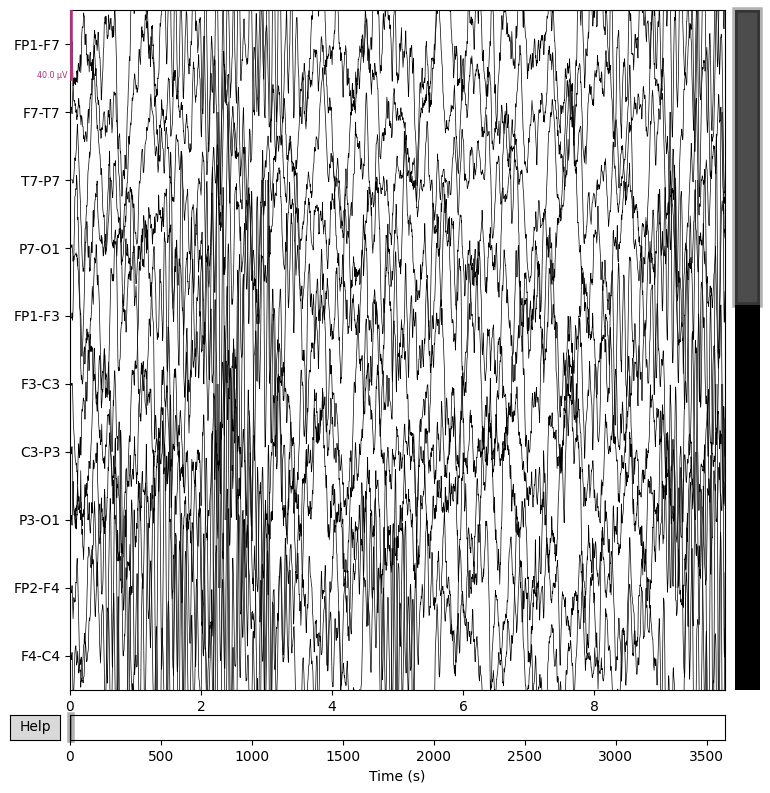

In [96]:
raw.plot(start=0, duration=10, n_channels=10, title="First 10 seconds of EEG");

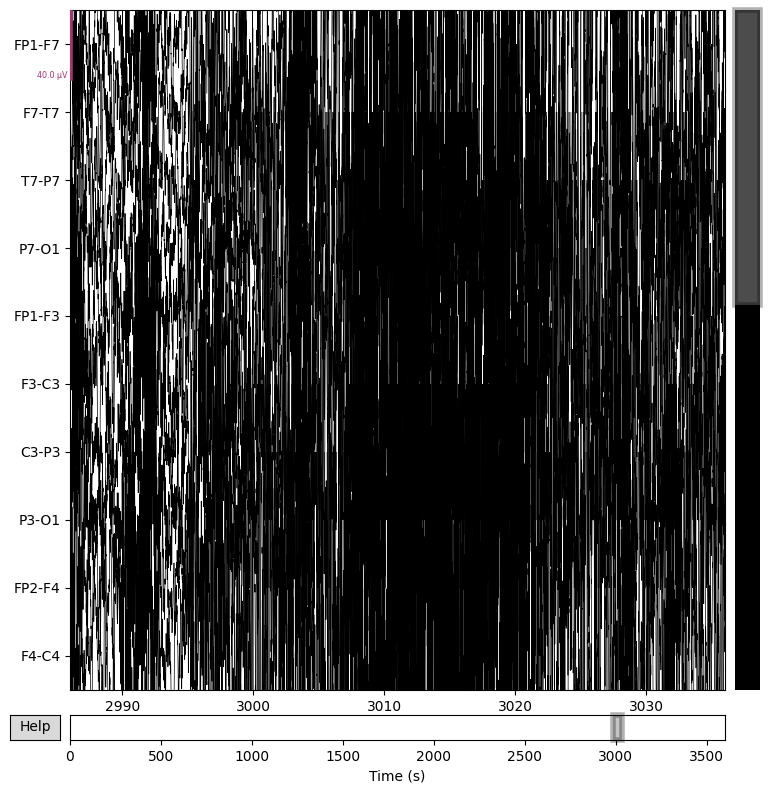

In [97]:
start, end = summary_df.loc[0, "seizure_intervals"][0] 

raw.plot(start=start-10, duration=50, n_channels=10,
         title=f"Seizure interval around {start}-{end} seconds");


In [98]:
def preprocess_raw(
    raw,
    l_freq=0.5,
    h_freq=40.0,
    notch_freq=60.0,
    resample_sfreq=128
):
    raw_prep = raw.copy()

    raw_prep.filter(l_freq=l_freq, h_freq=h_freq, fir_design="firwin", verbose=False)

    if notch_freq is not None:
        raw_prep.notch_filter(freqs=[notch_freq], verbose=False)

    if resample_sfreq is not None and resample_sfreq != raw_prep.info["sfreq"]:
        raw_prep.resample(resample_sfreq, verbose=False)

    return raw_prep

raw_prep = preprocess_raw(raw)

print("Original sfreq:", raw.info["sfreq"])
print("Preprocessed sfreq:", raw_prep.info["sfreq"])


Original sfreq: 256.0
Preprocessed sfreq: 128.0


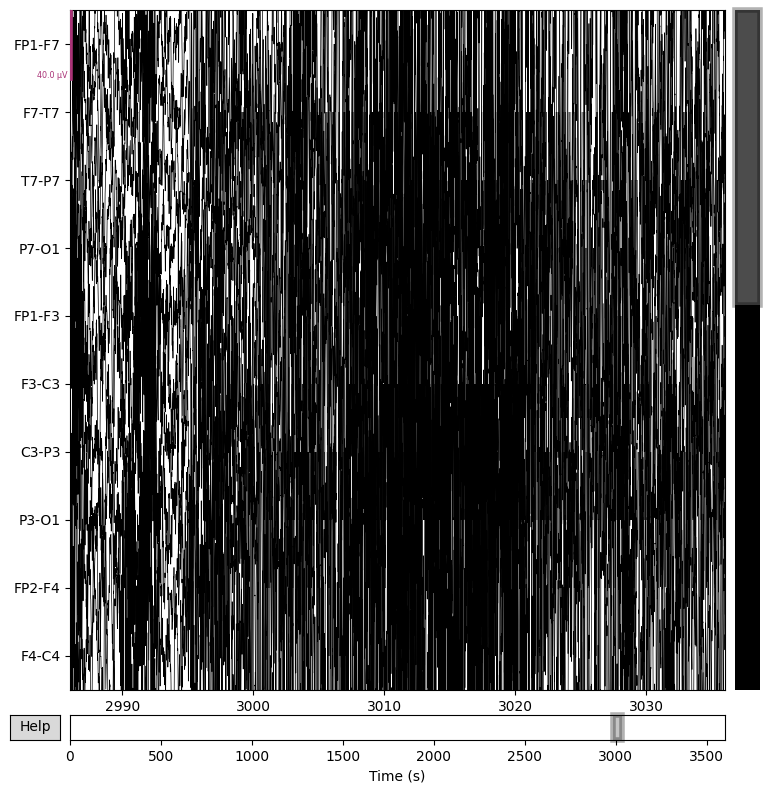

In [99]:
start, end = summary_df.loc[0, "seizure_intervals"][0]

raw_prep.plot(
    start=start - 10,
    duration=50,
    n_channels=10,
    title=f"Filtered EEG around seizure interval {start}-{end} s"
);


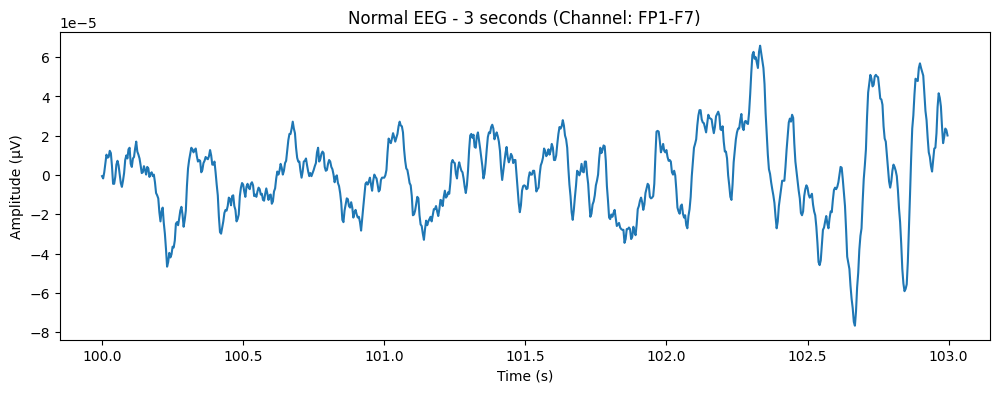

In [100]:
channel = 0

start_time_normal = 100
duration = 3

normal_data, times = raw[channel,
                         int(start_time_normal*raw.info['sfreq']) :
                         int((start_time_normal+duration)*raw.info['sfreq'])]

plt.figure(figsize=(12, 4))
plt.plot(times, normal_data[0])
plt.title("Normal EEG - 3 seconds (Channel: FP1-F7)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()


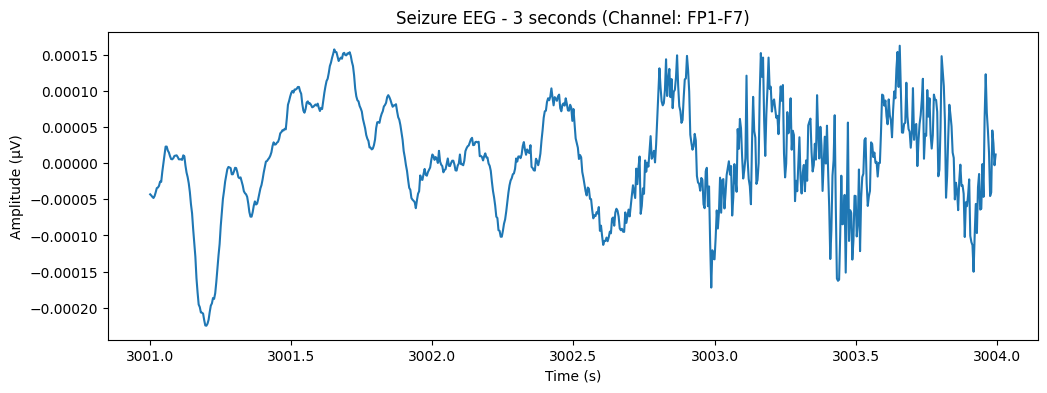

In [101]:
start_sz, end_sz = summary_df.loc[0, "seizure_intervals"][0]

start_time_seizure = start_sz + 5

sz_data, sz_times = raw[channel,
                        int(start_time_seizure*raw.info['sfreq']) :
                        int((start_time_seizure+duration)*raw.info['sfreq'])]

plt.figure(figsize=(12, 4))
plt.plot(sz_times, sz_data[0])
plt.title("Seizure EEG - 3 seconds (Channel: FP1-F7)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()


In [102]:
def create_windows(raw, seizure_intervals, window_size=10.0, step_size=5.0, overlap_sec=1.0):

    sfreq = raw.info['sfreq']
    win_samples = int(window_size * sfreq)
    step_samples = int(step_size * sfreq)
    n_samples = raw.n_times
    data = raw.get_data()

    windows = []
    labels = []

    for start in range(0, n_samples - win_samples, step_samples):
        end = start + win_samples
        start_time = start / sfreq
        end_time = end / sfreq

        segment = data[:, start:end]

        label = 0
        for (sz_start, sz_end) in seizure_intervals:
            overlap = max(0, min(end_time, sz_end) - max(start_time, sz_start))
            if overlap >= overlap_sec:
                label = 1
                break

        windows.append(segment)
        labels.append(label)

    return np.array(windows), np.array(labels)

example_intervals = summary_df.loc[0, "seizure_intervals"]
windows, labels = create_windows(raw_prep, example_intervals)

print("Windows shape:", windows.shape)
print("Labels distribution:", np.unique(labels, return_counts=True))


Windows shape: (718, 23, 1280)
Labels distribution: (array([0, 1]), array([708,  10]))


In [103]:
def process_all_files(
    summary_df,
    data_dir,
    window_size=10.0,
    step_size=5.0,
    overlap_sec=1.0
):
    all_windows = []
    all_labels = []
    all_file_ids = [] 

    for idx, row in summary_df.iterrows():
        fname = row["file"]
        intervals = row["seizure_intervals"]

        print(f"\n=== Processing {fname} ===")

        raw_path = os.path.join(data_dir, fname)
        raw = mne.io.read_raw_edf(raw_path, preload=True, verbose=False)

        raw_prep = preprocess_raw(raw)

        windows, labels = create_windows(
            raw_prep,
            seizure_intervals=intervals,
            window_size=window_size,
            step_size=step_size,
            overlap_sec=overlap_sec,
        )

        print("  windows:", windows.shape[0],
              " | seizure windows:", labels.sum(),
              " | non-seizure windows:", (labels == 0).sum())

        all_windows.append(windows.astype(np.float32))
        all_labels.append(labels.astype(int))
        all_file_ids.append(np.full(len(labels), idx, dtype=int))

    X = np.concatenate(all_windows, axis=0)   
    y = np.concatenate(all_labels, axis=0)  
    file_ids = np.concatenate(all_file_ids, axis=0)

    return X, y, file_ids


X, y, file_ids = process_all_files(summary_df, DATA_DIR)

print("\n=== Final dataset ===")
print("X shape (num_windows, channels, samples):", X.shape)
print("y shape:", y.shape)
print("Class distribution:", np.unique(y, return_counts=True))



=== Processing chb01_03.edf ===
  windows: 718  | seizure windows: 10  | non-seizure windows: 708

=== Processing chb01_04.edf ===
  windows: 718  | seizure windows: 10  | non-seizure windows: 708

=== Processing chb01_04.edf ===
  windows: 718  | seizure windows: 7  | non-seizure windows: 711

=== Processing chb01_15.edf ===
  windows: 718  | seizure windows: 7  | non-seizure windows: 711

=== Processing chb01_15.edf ===
  windows: 718  | seizure windows: 10  | non-seizure windows: 708

=== Processing chb01_16.edf ===
  windows: 718  | seizure windows: 10  | non-seizure windows: 708

=== Processing chb01_16.edf ===
  windows: 718  | seizure windows: 12  | non-seizure windows: 706

=== Processing chb01_18.edf ===
  windows: 718  | seizure windows: 12  | non-seizure windows: 706

=== Processing chb01_18.edf ===
  windows: 718  | seizure windows: 19  | non-seizure windows: 699

=== Processing chb01_21.edf ===
  windows: 718  | seizure windows: 19  | non-seizure windows: 699

=== Process

In [104]:
def normalize_windows(X):
    mean = X.mean(axis=2, keepdims=True)
    std = X.std(axis=2, keepdims=True) + 1e-8
    X_norm = (X - mean) / std
    return X_norm

X_norm = normalize_windows(X)
print("After normalization, shape:", X_norm.shape)


After normalization, shape: (4771, 23, 1280)


In [105]:
BONN_DIR = "./bonn_eeg" 

os.makedirs(BONN_DIR, exist_ok=True)

In [106]:
subset_labels = {
    "Z": 0,  # healthy, eyes open
    "O": 0,  # healthy, eyes closed
    "N": 0,  # interictal
    "F": 0,  # interictal
    "S": 1,  # ictal (seizure)
}

signals = []
labels = []
subset_ids = []

for subset, lab in subset_labels.items():
    subset_dir = os.path.join(BONN_DIR, subset)
    if not os.path.isdir(subset_dir):
        print(f"⚠️ Folder not found for subset {subset}: {subset_dir}")
        continue

    files = sorted(glob.glob(os.path.join(subset_dir, "*.txt")))
    print(f"Subset {subset}: found {len(files)} files")

    for fpath in files:
        sig = np.loadtxt(fpath)
        signals.append(sig.astype(np.float32))
        labels.append(lab)
        subset_ids.append(subset)

if len(signals) > 0:
    X_bonn = np.vstack([s[None, :] for s in signals]) 
    y_bonn = np.array(labels, dtype=int)
    subset_ids = np.array(subset_ids)
    
    print("\n✅ Bonn EEG loaded.")
    print("X_bonn shape:", X_bonn.shape) 
    print("y_bonn distribution:", np.unique(y_bonn, return_counts=True))
    print("Example segment length:", X_bonn.shape[1])
else:
    print("\n⚠️ No Bonn EEG signals loaded. Check that the data directories exist and contain .txt files.")
    X_bonn = None
    y_bonn = None
    subset_ids = None


Subset Z: found 100 files
Subset O: found 100 files
Subset N: found 100 files
Subset F: found 100 files
Subset S: found 100 files

✅ Bonn EEG loaded.
X_bonn shape: (500, 4097)
y_bonn distribution: (array([0, 1]), array([400, 100]))
Example segment length: 4097
Subset S: found 100 files

✅ Bonn EEG loaded.
X_bonn shape: (500, 4097)
y_bonn distribution: (array([0, 1]), array([400, 100]))
Example segment length: 4097


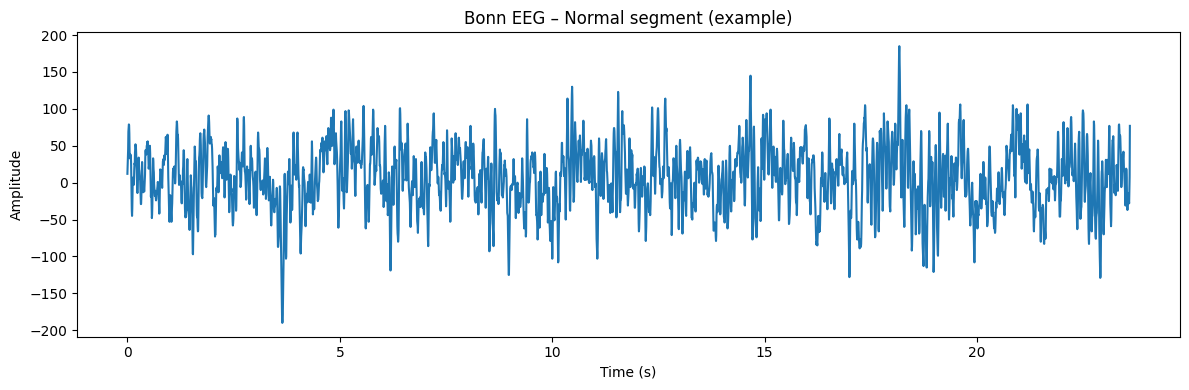

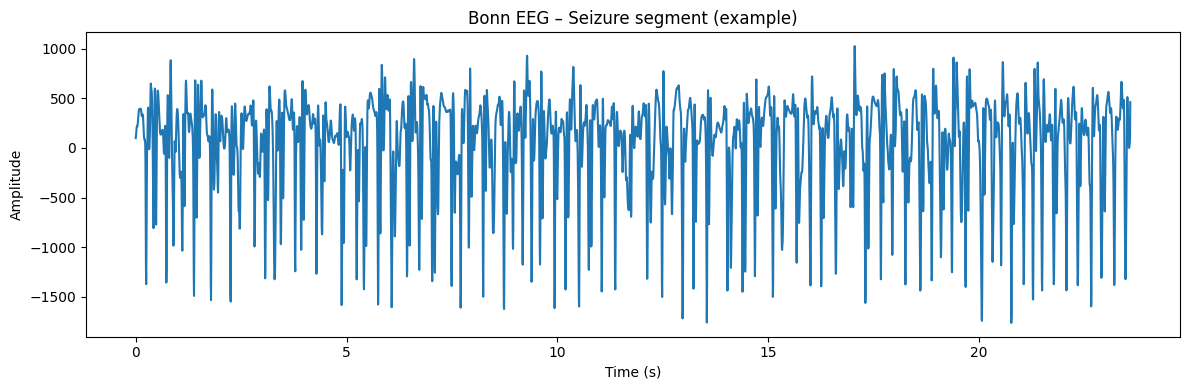

In [107]:
if X_bonn is not None:
    BONN_SFREQ = 173.6
    t = np.arange(X_bonn.shape[1]) / BONN_SFREQ
    
    idx_normal_bonn = np.where(y_bonn == 0)[0][0]
    idx_seizure_bonn = np.where(y_bonn == 1)[0][0]
    
    seg_normal = X_bonn[idx_normal_bonn]
    seg_seizure = X_bonn[idx_seizure_bonn]
    
    plt.figure(figsize=(12, 4))
    plt.plot(t, seg_normal)
    plt.title("Bonn EEG – Normal segment (example)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plt.plot(t, seg_seizure)
    plt.title("Bonn EEG – Seizure segment (example)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
else:
    print("Bonn data not loaded. Skipping visualization.")

In [108]:
if X_bonn is not None:
    BONN_SFREQ = 173.6
    
    def bandpass_filter_1d(sig, low=0.5, high=40.0, fs=BONN_SFREQ, order=4):
        nyq = 0.5 * fs
        b, a = signal.butter(order, [low / nyq, high / nyq], btype="band")
        return signal.filtfilt(b, a, sig)
    
    X_bonn_filt = np.array([bandpass_filter_1d(seg) for seg in X_bonn], dtype=np.float32)
    
    mean_bonn = X_bonn_filt.mean(axis=1, keepdims=True)
    std_bonn = X_bonn_filt.std(axis=1, keepdims=True) + 1e-8
    X_bonn_norm = (X_bonn_filt - mean_bonn) / std_bonn
    
    print("Filtered + normalized Bonn shape:", X_bonn_norm.shape)
else:
    print("Bonn data not loaded. Skipping filtering.")

Filtered + normalized Bonn shape: (500, 4097)


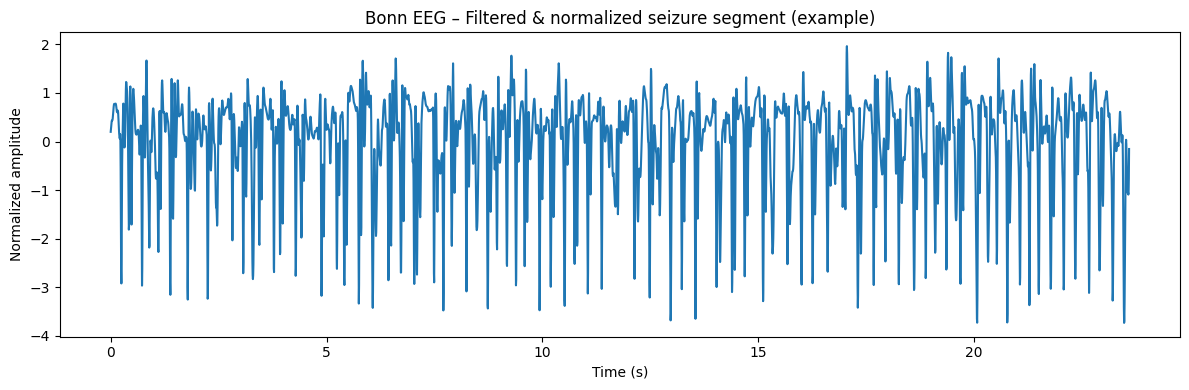

In [109]:
if X_bonn is not None and 'X_bonn_norm' in locals():
    plt.figure(figsize=(12,4))
    plt.plot(t, X_bonn_norm[idx_seizure_bonn])
    plt.title("Bonn EEG – Filtered & normalized seizure segment (example)")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized amplitude")
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot: Bonn data or filtered data not available.")

Feature Extraction

In [110]:
from scipy.integrate import trapezoid
from scipy.stats import skew, kurtosis

def compute_basic_features_1d(sig, fs):
    sig = np.asarray(sig, dtype=float)
    feats = []
    
    feats.append(sig.mean())         
    feats.append(sig.std())       
    feats.append(skew(sig))          
    feats.append(kurtosis(sig))            
    feats.append(sig.min())               
    feats.append(sig.max())                 
    feats.append(np.ptp(sig))              
    feats.append(np.sum(sig**2) / len(sig))

    freqs, psd = signal.welch(sig, fs, nperseg=min(256, len(sig)))

    def bandpower(f_lo, f_hi):
        idx = (freqs >= f_lo) & (freqs <= f_hi)
        if not np.any(idx):
            return 0.0
        return trapezoid(psd[idx], freqs[idx])

    feats.append(bandpower(0.5, 4))   
    feats.append(bandpower(4, 8))    
    feats.append(bandpower(8, 13))    
    feats.append(bandpower(13, 30))  
    feats.append(bandpower(30, 40))  

    return np.array(feats, dtype=np.float32)

In [111]:
SFREQ_CHB = 128.0
chb_features = [
    compute_basic_features_1d(win.mean(axis=0), SFREQ_CHB)
    for win in X_norm
]
X_chb_feat = np.vstack(chb_features)

print("CHB-MIT feature matrix shape:", X_chb_feat.shape)
print("CHB-MIT labels distribution:", np.unique(y, return_counts=True))

if X_bonn is not None and 'X_bonn_norm' in locals():
    bonn_features = [
        compute_basic_features_1d(seg, 173.6)
        for seg in X_bonn_norm
    ]
    X_bonn_feat = np.vstack(bonn_features)
    
    print("\nBonn feature matrix shape:", X_bonn_feat.shape)
    print("Bonn labels distribution:", np.unique(y_bonn, return_counts=True))
else:
    print("\nBonn data not available for feature extraction.")

CHB-MIT feature matrix shape: (4771, 13)
CHB-MIT labels distribution: (array([0, 1]), array([4671,  100]))

Bonn feature matrix shape: (500, 13)
Bonn labels distribution: (array([0, 1]), array([400, 100]))

Bonn feature matrix shape: (500, 13)
Bonn labels distribution: (array([0, 1]), array([400, 100]))


In [112]:
def stratified_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=(1.0 - train_size),
        stratify=y,
        random_state=random_state
    )
    
    val_ratio = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=(1.0 - val_ratio),
        stratify=y_temp,
        random_state=random_state
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_chb_train, X_chb_val, X_chb_test, y_chb_train, y_chb_val, y_chb_test = stratified_split(
    X_chb_feat, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42
)

print("CHB-MIT shapes:")
print("  Train:", X_chb_train.shape, "labels:", np.unique(y_chb_train, return_counts=True))
print("  Val  :", X_chb_val.shape,  "labels:", np.unique(y_chb_val,  return_counts=True))
print("  Test :", X_chb_test.shape, "labels:", np.unique(y_chb_test, return_counts=True))

if X_bonn is not None and 'X_bonn_feat' in locals():
    X_bonn_train, X_bonn_val, X_bonn_test, y_bonn_train, y_bonn_val, y_bonn_test = stratified_split(
        X_bonn_feat, y_bonn, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42
    )
    
    print("\nBonn shapes:")
    print("  Train:", X_bonn_train.shape, "labels:", np.unique(y_bonn_train, return_counts=True))
    print("  Val  :", X_bonn_val.shape,  "labels:", np.unique(y_bonn_val,  return_counts=True))
    print("  Test :", X_bonn_test.shape, "labels:", np.unique(y_bonn_test, return_counts=True))
else:
    print("\nBonn data not available for splitting.")

CHB-MIT shapes:
  Train: (3339, 13) labels: (array([0, 1]), array([3269,   70]))
  Val  : (716, 13) labels: (array([0, 1]), array([701,  15]))
  Test : (716, 13) labels: (array([0, 1]), array([701,  15]))

Bonn shapes:
  Train: (349, 13) labels: (array([0, 1]), array([279,  70]))
  Val  : (75, 13) labels: (array([0, 1]), array([60, 15]))
  Test : (76, 13) labels: (array([0, 1]), array([61, 15]))


In [113]:
rf_chb = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight="balanced", 
    n_jobs=-1
)

rf_chb.fit(X_chb_train, y_chb_train)

y_chb_val_pred = rf_chb.predict(X_chb_val)

print("=== CHB-MIT Validation Performance (RandomForest) ===")
print(classification_report(y_chb_val, y_chb_val_pred, digits=4))
print("Confusion matrix (val):")
print(confusion_matrix(y_chb_val, y_chb_val_pred))


=== CHB-MIT Validation Performance (RandomForest) ===
              precision    recall  f1-score   support

           0     0.9818    1.0000    0.9908       701
           1     1.0000    0.1333    0.2353        15

    accuracy                         0.9818       716
   macro avg     0.9909    0.5667    0.6131       716
weighted avg     0.9822    0.9818    0.9750       716

Confusion matrix (val):
[[701   0]
 [ 13   2]]


In [114]:
y_chb_test_pred = rf_chb.predict(X_chb_test)

print("=== CHB-MIT Test Performance (RandomForest) ===")
print(classification_report(y_chb_test, y_chb_test_pred, digits=4))
print("Confusion matrix (test):")
print(confusion_matrix(y_chb_test, y_chb_test_pred))


=== CHB-MIT Test Performance (RandomForest) ===
              precision    recall  f1-score   support

           0     0.9804    1.0000    0.9901       701
           1     1.0000    0.0667    0.1250        15

    accuracy                         0.9804       716
   macro avg     0.9902    0.5333    0.5576       716
weighted avg     0.9808    0.9804    0.9720       716

Confusion matrix (test):
[[701   0]
 [ 14   1]]


In [115]:
if X_bonn is not None and 'X_bonn_train' in locals():
    rf_bonn = RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    
    rf_bonn.fit(X_bonn_train, y_bonn_train)
    
    y_bonn_val_pred = rf_bonn.predict(X_bonn_val)
    print("=== BONN Validation Performance ===")
    print(classification_report(y_bonn_val, y_bonn_val_pred, digits=4))
    print("Confusion matrix (val):")
    print(confusion_matrix(y_bonn_val, y_bonn_val_pred))
    
    y_bonn_test_pred = rf_bonn.predict(X_bonn_test)
    print("\n=== BONN Test Performance ===")
    print(classification_report(y_bonn_test, y_bonn_test_pred, digits=4))
    print("Confusion matrix (test):")
    print(confusion_matrix(y_bonn_test, y_bonn_test_pred))
else:
    print("Bonn data not available for model training.")

=== BONN Validation Performance ===
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        60
           1     1.0000    0.6000    0.7500        15

    accuracy                         0.9200        75
   macro avg     0.9545    0.8000    0.8512        75
weighted avg     0.9273    0.9200    0.9119        75

Confusion matrix (val):
[[60  0]
 [ 6  9]]

=== BONN Test Performance ===
              precision    recall  f1-score   support

           0     0.9531    1.0000    0.9760        61
           1     1.0000    0.8000    0.8889        15

    accuracy                         0.9605        76
   macro avg     0.9766    0.9000    0.9324        76
weighted avg     0.9624    0.9605    0.9588        76

Confusion matrix (test):
[[61  0]
 [ 3 12]]


In [116]:
X_cnn = np.transpose(X_norm, (0, 2, 1))  

print("CNN input shape:", X_cnn.shape)

X_train_cnn, X_temp_cnn, y_train_cnn, y_temp_cnn = train_test_split(
    X_cnn, y, test_size=0.3, stratify=y, random_state=42
)

X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(
    X_temp_cnn, y_temp_cnn, test_size=0.5, stratify=y_temp_cnn, random_state=42
)

print("Train:", X_train_cnn.shape, "labels:", np.unique(y_train_cnn, return_counts=True))
print("Val:", X_val_cnn.shape, "labels:", np.unique(y_val_cnn, return_counts=True))
print("Test:", X_test_cnn.shape, "labels:", np.unique(y_test_cnn, return_counts=True))


CNN input shape: (4771, 1280, 23)
Train: (3339, 1280, 23) labels: (array([0, 1]), array([3269,   70]))
Val: (716, 1280, 23) labels: (array([0, 1]), array([701,  15]))
Test: (716, 1280, 23) labels: (array([0, 1]), array([701,  15]))


In [117]:
input_shape = (1280, 23)

cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1280, 32)       │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 640, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 640, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 320, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 320, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 160, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,661,889 (10.15 MB)

 Trainable params: 2,661,889 (10.15 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9775 - loss: 0.3728 - val_accuracy: 0.9791 - val_loss: 0.0640
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.9775 - loss: 0.3728 - val_accuracy: 0.9791 - val_loss: 0.0640
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9790 - loss: 0.0506 - val_accuracy: 0.9791 - val_loss: 0.0374
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9790 - loss: 0.0506 - val_accuracy: 0.9791 - val_loss: 0.0374
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9844 - loss: 0.0309 - val_accuracy: 0.9874 - val_loss: 0.0370
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9844 - loss: 0.0309 - val_accuracy: 0.9874 - val_loss: 0.0370
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9922 - loss: 0.0236 - val_accuracy: 0.9832 - val_loss: 0.0411
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9922 - loss: 0.0236 - val_accu

In [119]:
val_pred = (cnn_model.predict(X_val_cnn) > 0.5).astype(int)
print("=== CNN Validation Performance (CHB-MIT) ===")
print(classification_report(y_val_cnn, val_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_val_cnn, val_pred))

test_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype(int)
print("\n=== CNN Test Performance (CHB-MIT) ===")
print(classification_report(y_test_cnn, test_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_cnn, test_pred))


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== CNN Validation Performance (CHB-MIT) ===
              precision    recall  f1-score   support

           0     0.9957    1.0000    0.9979       701
           1     1.0000    0.8000    0.8889        15

    accuracy                         0.9958       716
   macro avg     0.9979    0.9000    0.9434       716
weighted avg     0.9958    0.9958    0.9956       716

Confusion Matrix:
[[701   0]
 [  3  12]]
=== CNN Validation Performance (CHB-MIT) ===
              precision    recall  f1-score   support

           0     0.9957    1.0000    0.9979       701
           1     1.0000    0.8000    0.8889        15

    accuracy                         0.9958       716
   macro avg     0.9979    0.9000    0.9434       716
weighted avg     0.9958    0.9958    0.9956       716

Confusion Matrix:
[[701   0]
 [  3  12]]
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

=== CNN Test 

In [120]:
input_shape = (1280, 23)

lstm_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

lstm_model.summary()

early_stop_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_lstm = lstm_model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_val_cnn, y_val_cnn),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop_lstm],
    verbose=1
)

val_pred_lstm = (lstm_model.predict(X_val_cnn) > 0.5).astype(int)
print("=== LSTM Validation Performance (CHB-MIT) ===")
print(classification_report(y_val_cnn, val_pred_lstm, digits=4))
print("Confusion Matrix (val):")
print(confusion_matrix(y_val_cnn, val_pred_lstm))

test_pred_lstm = (lstm_model.predict(X_test_cnn) > 0.5).astype(int)
print("\n=== LSTM Test Performance (CHB-MIT) ===")
print(classification_report(y_test_cnn, test_pred_lstm, digits=4))
print("Confusion Matrix (test):")
print(confusion_matrix(y_test_cnn, test_pred_lstm))

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,753 (104.50 KB)

 Trainable params: 26,753 (104.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.9260 - loss: 0.2583 - val_accuracy: 0.9791 - val_loss: 0.1019
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.9260 - loss: 0.2583 - val_accuracy: 0.9791 - val_loss: 0.1019
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9790 - loss: 0.1181 - val_accuracy: 0.9791 - val_loss: 0.1009
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9790 - loss: 0.1181 - val_accuracy: 0.9791 - val_loss: 0.1009
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.9790 - loss: 0.1095 - val_accuracy: 0.9791 - val_loss: 0.1033
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - accuracy: 0.9790 - loss: 0.1095 - val_accuracy: 0.9791 - val_loss: 0.1033
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9790 - loss: 0.1046 - val_accuracy: 0.9791 - val_loss: 0.1065
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9790 - loss: 0

In [121]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal','Seizure'],
                yticklabels=['Normal','Seizure'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


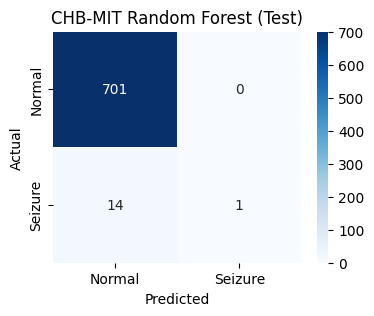

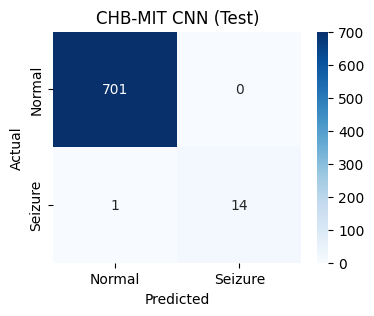

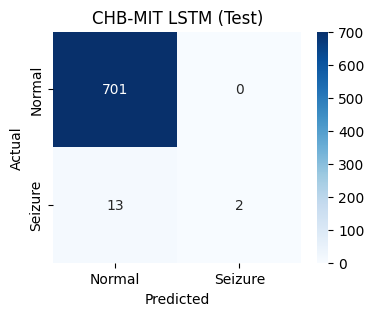

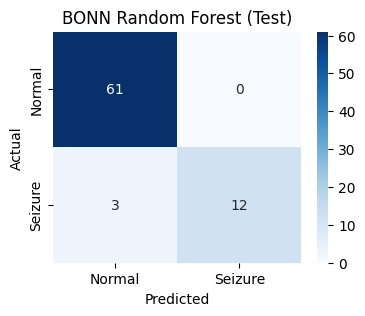

In [122]:
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Normal','Seizure'],
                yticklabels=['Normal','Seizure'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_conf_matrix(y_chb_test, y_chb_test_pred, "CHB-MIT Random Forest (Test)")
plot_conf_matrix(y_test_cnn, test_pred, "CHB-MIT CNN (Test)")
plot_conf_matrix(y_test_cnn, test_pred_lstm, "CHB-MIT LSTM (Test)")

if X_bonn is not None and 'y_bonn_test_pred' in locals():
    plot_conf_matrix(y_bonn_test, y_bonn_test_pred, "BONN Random Forest (Test)")

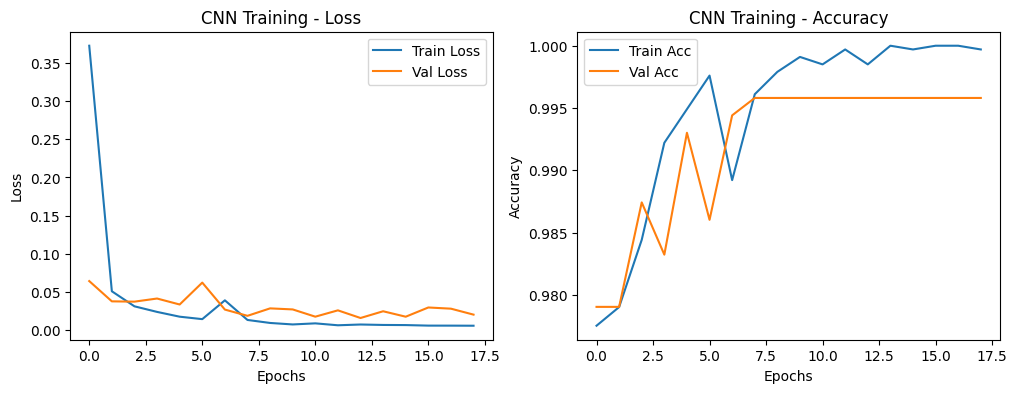

In [123]:
def plot_training_history(history, title):
    plt.figure(figsize=(12,4))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + " - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title + " - Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

plot_training_history(history, "CNN Training")


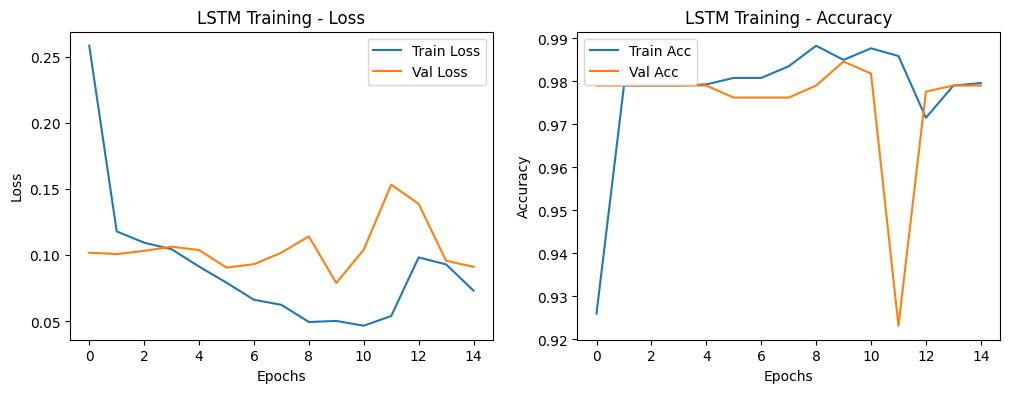

In [124]:
plot_training_history(history_lstm, "LSTM Training")

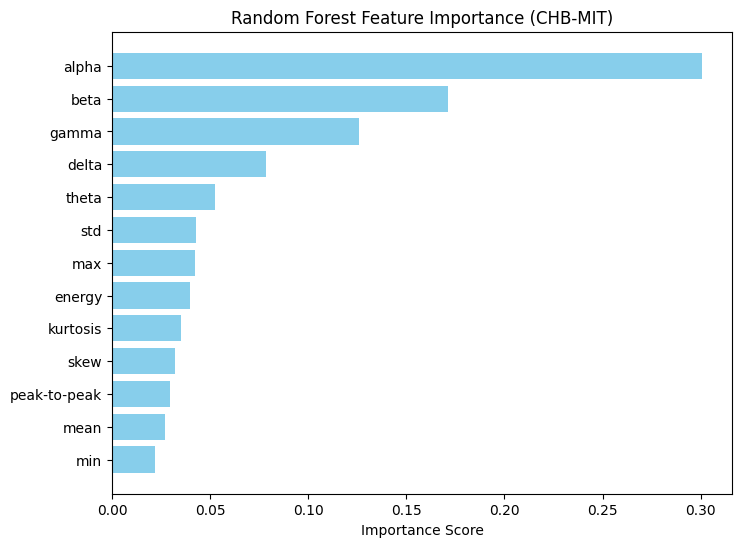

In [125]:
feature_names = [
    "mean", "std", "skew", "kurtosis",
    "min", "max", "peak-to-peak", "energy",
    "delta", "theta", "alpha", "beta", "gamma"
]

importances = rf_chb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,6))
plt.barh(np.array(feature_names)[indices], importances[indices], color='skyblue')
plt.title("Random Forest Feature Importance (CHB-MIT)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.show()


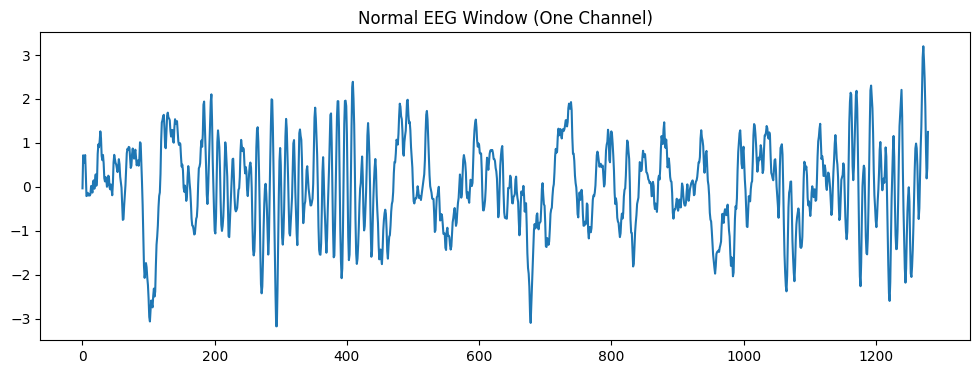

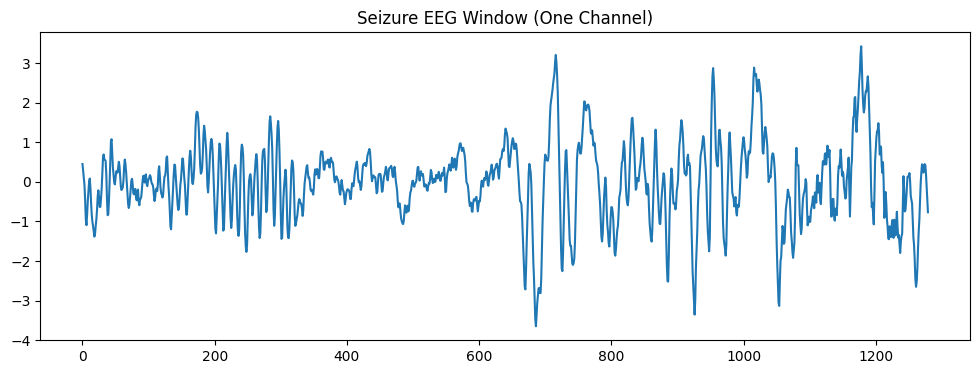

In [126]:
normal_idx = np.where(y == 0)[0][0]
seizure_idx = np.where(y == 1)[0][0]

plt.figure(figsize=(12,4))
plt.plot(X_norm[normal_idx][0])  
plt.title("Normal EEG Window (One Channel)")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(X_norm[seizure_idx][0]) 
plt.title("Seizure EEG Window (One Channel)")
plt.show()


In [127]:
from sklearn.metrics import roc_auc_score, roc_curve

test_pred_lstm = (lstm_model.predict(X_test_cnn) > 0.5).astype(int)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step


In [128]:
lstm_recall = recall_score(y_test_cnn, test_pred_lstm)
print("LSTM Test Recall:", lstm_recall)


LSTM Test Recall: 0.13333333333333333


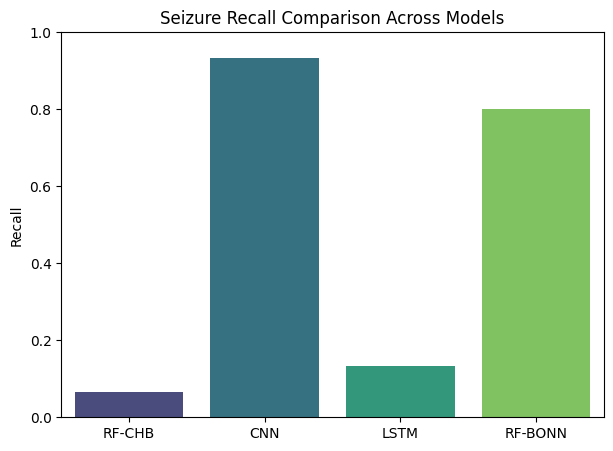


Recall scores:
  RF-CHB: 0.0667
  CNN: 0.9333
  LSTM: 0.1333
  RF-BONN: 0.8000


In [129]:
from sklearn.metrics import recall_score as compute_recall

rf_chb_recall = compute_recall(y_chb_test, y_chb_test_pred)
cnn_recall = compute_recall(y_test_cnn, test_pred)
lstm_test_recall = compute_recall(y_test_cnn, test_pred_lstm)

model_names = ["RF-CHB", "CNN", "LSTM"]
recalls = [rf_chb_recall, cnn_recall, lstm_test_recall]

if X_bonn is not None and 'y_bonn_test_pred' in locals():
    bonn_recall = compute_recall(y_bonn_test, y_bonn_test_pred)
    model_names.append("RF-BONN")
    recalls.append(bonn_recall)

plt.figure(figsize=(7,5))
sns.barplot(x=model_names, y=recalls, hue=model_names, palette="viridis", legend=False)
plt.title("Seizure Recall Comparison Across Models")
plt.ylabel("Recall")
plt.ylim(0,1)
plt.show()

print("\nRecall scores:")
for name, recall in zip(model_names, recalls):
    print(f"  {name}: {recall:.4f}")